In [1]:
import os
import torchvision
from PIL import Image
from torchvision import datasets, models, transforms
import torch

# number of subprocesses to use for data loading
num_workers = 0
classes=2

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transform = transforms.Compose([
         transforms.RandomRotation(30),
         transforms.RandomHorizontalFlip(),
         transforms.RandomResizedCrop(224),            
         transforms.ToTensor()
         ])

transform = transforms.Compose([
         transforms.Resize(256),                    
         transforms.CenterCrop(224),                
         transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder('images', transform=train_transform, target_transform=None, loader=Image.open, is_valid_file=None)
valid_data = torchvision.datasets.ImageFolder('images', transform=transform, target_transform=None, loader=Image.open, is_valid_file=None)

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# instantiate the CNN
model_transfer = models.mobilenet_v2(pretrained=True)

print(model_transfer)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
# Deactivate gradient for pretrained layers - Prevents them from training
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
# new layers automatically have requires_grad = True
n_inputs = model_transfer.classifier[1].in_features
last_layer = nn.Linear(n_inputs, len(train_data.classes))

model_transfer.classifier[1] = last_layer


# check to see that your last layer produces the expected number of outputs
print('Output Count: {}'.format(last_layer.out_features))

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()

Output Count: 2


In [5]:
from torchsummary import summary
summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [6]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, starting_loss):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = starting_loss 
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)----------------------------------------------------------------
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
           if use_cuda:            
               data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
           output = model(data)
            # calculate the batch loss
           loss = criterion(output, target)
            # update average validation loss 
           valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model




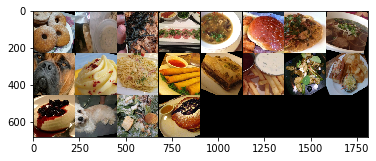

Training Data inputs torch.Size([20, 3, 224, 224])  Classestorch.Size([20])


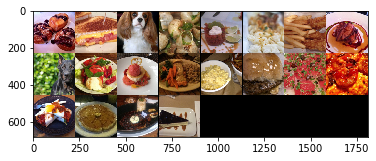

Validation Data inputs torch.Size([20, 3, 224, 224])  Classestorch.Size([20])


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from glob import glob
from torch.utils.data import SubsetRandomSampler

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.5, 0.5, 0.5])
    #std = np.array([0.5, 0.5, 0.5])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    
# how many samples per batch to load
batch_size = 20 #lowered batch size due to running out of memory

# prepare data loaders - had to move them because of changing the batch size
loaders_transfer={}

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.9 * dataset_size))
# np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

loaders_transfer['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler)
loaders_transfer['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                                sampler=valid_sampler)

# obtain one batch of training images
dataiter = iter(loaders_transfer['train'])
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(loaders_transfer['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)
print('Training Data inputs {}  Classes{}'.format(inputs.shape, classes.shape))
      
# obtain one batch of training images
dataiter2 = iter(loaders_transfer['valid'])
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(loaders_transfer['valid']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)
print('Validation Data inputs {}  Classes{}'.format(inputs.shape, classes.shape))

In [8]:
import torch.optim as optim

### TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9, nesterov=True)

training_from_base=True
update_training=False

In [9]:
#Training from scratch
if(training_from_base):
    #change the starting_loss if continuing on a saved model.
    starting_loss=np.inf
    # train the model
    model_transfer = train(200, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, '/home/paolo/models/model_transfer.pt', starting_loss)

    # load the model that got the best validation accuracy
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))

  0%|          | 1/200 [08:46<29:06:26, 526.57s/it]

Epoch: 1 	Training Loss: 0.058766 	Validation Loss: 0.011468
Validation loss decreased (inf --> 0.011468).  Saving model ...


  1%|          | 2/200 [17:37<29:02:15, 527.96s/it]

Epoch: 2 	Training Loss: 0.025219 	Validation Loss: 0.008437
Validation loss decreased (0.011468 --> 0.008437).  Saving model ...


  2%|▏         | 3/200 [26:30<28:58:22, 529.46s/it]

Epoch: 3 	Training Loss: 0.018953 	Validation Loss: 0.006759
Validation loss decreased (0.008437 --> 0.006759).  Saving model ...


  2%|▏         | 4/200 [35:21<28:50:40, 529.80s/it]

Epoch: 4 	Training Loss: 0.017995 	Validation Loss: 0.005892
Validation loss decreased (0.006759 --> 0.005892).  Saving model ...


  2%|▎         | 5/200 [44:11<28:42:15, 529.93s/it]

Epoch: 5 	Training Loss: 0.016974 	Validation Loss: 0.004710
Validation loss decreased (0.005892 --> 0.004710).  Saving model ...


  3%|▎         | 6/200 [53:02<28:34:16, 530.19s/it]

Epoch: 6 	Training Loss: 0.015080 	Validation Loss: 0.006377


  4%|▎         | 7/200 [1:01:54<28:27:10, 530.73s/it]

Epoch: 7 	Training Loss: 0.014077 	Validation Loss: 0.004109
Validation loss decreased (0.004710 --> 0.004109).  Saving model ...


  4%|▍         | 8/200 [1:10:49<28:22:35, 532.06s/it]

Epoch: 8 	Training Loss: 0.012873 	Validation Loss: 0.005222


  4%|▍         | 9/200 [1:19:38<28:10:50, 531.15s/it]

Epoch: 9 	Training Loss: 0.013503 	Validation Loss: 0.004112


  5%|▌         | 10/200 [1:28:28<28:00:55, 530.82s/it]

Epoch: 10 	Training Loss: 0.013307 	Validation Loss: 0.003080
Validation loss decreased (0.004109 --> 0.003080).  Saving model ...


  6%|▌         | 11/200 [1:37:21<27:53:38, 531.32s/it]

Epoch: 11 	Training Loss: 0.012638 	Validation Loss: 0.005332


  6%|▌         | 12/200 [1:46:15<27:47:59, 532.34s/it]

Epoch: 12 	Training Loss: 0.012337 	Validation Loss: 0.003335


  6%|▋         | 13/200 [1:55:08<27:39:25, 532.44s/it]

Epoch: 13 	Training Loss: 0.013945 	Validation Loss: 0.003262


  7%|▋         | 14/200 [2:04:00<27:30:25, 532.40s/it]

Epoch: 14 	Training Loss: 0.013394 	Validation Loss: 0.003828


  8%|▊         | 15/200 [2:12:52<27:21:21, 532.33s/it]

Epoch: 15 	Training Loss: 0.012306 	Validation Loss: 0.003214


  8%|▊         | 16/200 [2:21:46<27:13:24, 532.63s/it]

Epoch: 16 	Training Loss: 0.013129 	Validation Loss: 0.002548
Validation loss decreased (0.003080 --> 0.002548).  Saving model ...


  8%|▊         | 17/200 [2:30:38<27:04:36, 532.66s/it]

Epoch: 17 	Training Loss: 0.012044 	Validation Loss: 0.004843


  9%|▉         | 18/200 [2:39:30<26:54:19, 532.20s/it]

Epoch: 18 	Training Loss: 0.010651 	Validation Loss: 0.002473
Validation loss decreased (0.002548 --> 0.002473).  Saving model ...


 10%|▉         | 19/200 [2:48:20<26:44:03, 531.73s/it]

Epoch: 19 	Training Loss: 0.010275 	Validation Loss: 0.002922


 10%|█         | 20/200 [2:57:11<26:34:18, 531.44s/it]

Epoch: 20 	Training Loss: 0.010416 	Validation Loss: 0.002163
Validation loss decreased (0.002473 --> 0.002163).  Saving model ...


 10%|█         | 21/200 [3:06:01<26:24:34, 531.14s/it]

Epoch: 21 	Training Loss: 0.010337 	Validation Loss: 0.002534


 11%|█         | 22/200 [3:14:53<26:16:23, 531.37s/it]

Epoch: 22 	Training Loss: 0.011594 	Validation Loss: 0.003048


 12%|█▏        | 23/200 [3:23:43<26:05:53, 530.81s/it]

Epoch: 23 	Training Loss: 0.011262 	Validation Loss: 0.003189


 12%|█▏        | 24/200 [3:32:34<25:56:58, 530.79s/it]

Epoch: 24 	Training Loss: 0.010840 	Validation Loss: 0.002858


 12%|█▎        | 25/200 [3:41:23<25:47:16, 530.50s/it]

Epoch: 25 	Training Loss: 0.010160 	Validation Loss: 0.002791


KeyboardInterrupt: 

In [ ]:
#reload and continue training
if(update_training):   
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    if use_cuda:
        model_transfer.cuda()

    #change the starting_loss if continuing on a saved model.
    starting_loss=1.778868
    # train the model
    model_transfer = train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, '/home/paolo/models/model_transfer.pt', starting_loss)

    # load the model that got the best validation accuracy
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [24]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

transform = transforms.Compose([
         transforms.Resize(256),                    
         transforms.CenterCrop(224),                
         transforms.ToTensor()
         ])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

classes = train_data.classes

testimage = image_loader(transform, 'oneoff/dogdoughnut.jpeg')

def test(timage, model, use_cuda):
    model.eval()
    # move to GPU
    if use_cuda:
        model.cuda()
        timage = timage.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    testoutput = model(timage)
    # convert output probabilities to predicted class
    pred = testoutput.data.softmax(dim=1)
    # compare predictions to true label
    indices = pred[0].cpu()
    if indices[0]>indices[1]:
        print("I think it's a dog")
    else:
        print("I think it's food")
    #for ind in range(len(indices[0])):
    #    print('{}. {:>6.2%} - {} '.format(ind, pred[0][0][ind], classes[indices[0][ind]]))
    #print('Results : {} {} {} {} {}'.format(
    #    classes[pred[1][0]]), classes[pred[1][1]], classes[pred[1][2]], classes[pred[1][3]], classes[pred[1][4]]
    #     )


# call test function    
test(testimage, model_transfer, use_cuda)


I think it's a dog


/home/paolo/anaconda3/envs/udacity2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
